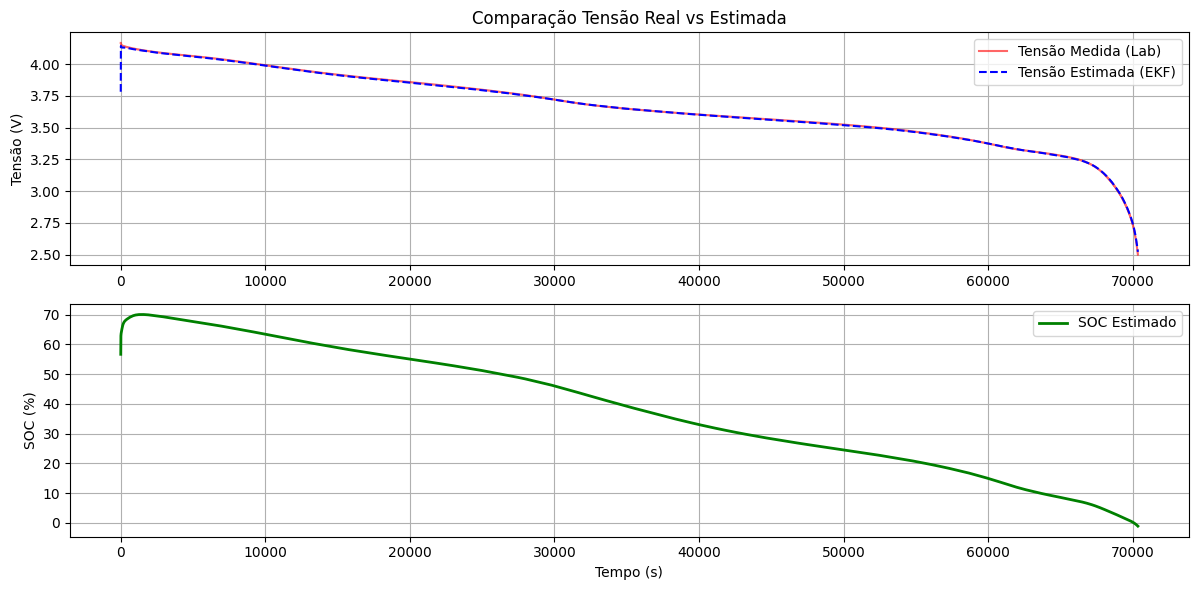

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. CARREGAR DADOS REAIS ---
nome_arquivo = 'BID001_DchConst005_29072024.txt'

df = pd.read_csv(nome_arquivo, sep=';') 

coluna_tempo   = 'time' 
coluna_tensao  = 'voltage'
coluna_corrente= 'current'

# Extraindo os vetores
t_real = df[coluna_tempo].values
v_real = df[coluna_tensao].values
i_real = df[coluna_corrente].values

# --- 2. PARÂMETROS DA BATERIA (Do PDF) ---
R1 = 0.009818
R2 = 0.031463
C1 = 15639.0
C2 = 39332.0
Q_cap = 3.08 * 3600  # Capacidade total em As

# Polinômios (Com a correção de escala aplicada)
alpha_coeffs = np.array([0.140437, -0.693293, 1.448317, -1.665299, 1.148704, 
                         -0.486836, 0.125421, -0.01891, 0.001657, 0.000269]) * 1e4

beta_coeffs  = np.array([0.440568, -2.188575, 4.662025, -5.561277, 4.069003, 
                         -1.878727, 0.541296, -0.092097, 0.008056, -0.000161]) * 1e3

alpha_deriv = np.polyder(alpha_coeffs)
beta_deriv  = np.polyder(beta_coeffs)

# --- 3. CONFIGURAÇÃO DO EKF ---
# Incertezas
Q_proc = np.diag([1e-6, 1e-6, 1e-7]) # Ruído do processo
R_meas = 0.04                        # Confiança no seu sensor

# Inicialização do Estado
x_est = np.array([[0], [0], [0.5]]) # [v1, v2, SOC]
P_est = np.eye(3) * 1e-2            # Incerteza inicial

# Listas para guardar histórico
hist_soc_estimado = []
hist_v_estimado   = []

# --- 4. LOOP DO FILTRO DE KALMAN ---
N = len(t_real)

for k in range(N):
    
    # 4.1. Definir Entradas
    u = i_real[k] # Corrente real do arquivo
    z = v_real[k] # Tensão real do arquivo (Sensor)
    
    Ts = 1

    # Atualizar Matrizes A e B com o Ts atual
    A_model = np.array([
        [1 - Ts/(R1*C1), 0, 0],
        [0, 1 - Ts/(R2*C2), 0],
        [0, 0, 1]
    ])
    B_model = np.array([
        [Ts/C1],
        [Ts/C2],
        [-Ts/Q_cap]
    ])

    # --- PASSO A: PREDIÇÃO ---
    x_pred = A_model @ x_est + B_model * u
    P_pred = A_model @ P_est @ A_model.T + Q_proc
    
    # --- PASSO B: CORREÇÃO ---
    # Calcular saídas esperadas (usando polinômios)
    soc_p = x_pred[2, 0]
    
    # # Trava de segurança para o polinômio não explodir fora de 0-1
    # soc_p = np.clip(soc_p, 0.0, 1.0) 

    v1_p  = x_pred[0, 0]
    v2_p  = x_pred[1, 0]
    
    voc_est = np.polyval(alpha_coeffs, soc_p)
    r0_est  = np.polyval(beta_coeffs, soc_p)
    
    # Tensão estimada pelo modelo
    y_pred = voc_est - v1_p - v2_p - (r0_est * u)
    
    # Linearização (Jacobiana C)
    dVoc_dSOC = np.polyval(alpha_deriv, soc_p)
    dR0_dSOC  = np.polyval(beta_deriv, soc_p)
    C = np.array([[-1, -1, dVoc_dSOC - (u * dR0_dSOC)]])
    
    # Ganho de Kalman
    S = C @ P_pred @ C.T + R_meas
    K = P_pred @ C.T @ np.linalg.inv(S)
    
    # Atualização Final
    inovacao = z - y_pred
    x_est = x_pred + K * inovacao
    P_est = (np.eye(3) - K @ C) @ P_pred
    
    # Guardar dados
    hist_soc_estimado.append(x_est[2, 0])
    hist_v_estimado.append(y_pred)

# --- 5. VISUALIZAÇÃO ---
plt.figure(figsize=(12, 6))

# Subplot 1: Tensão
plt.subplot(2, 1, 1)
plt.plot(t_real, v_real, 'r', label='Tensão Medida (Lab)', alpha=0.6)
plt.plot(t_real, hist_v_estimado, 'b--', label='Tensão Estimada (EKF)')
plt.ylabel('Tensão (V)')
plt.legend()
plt.grid(True)
plt.title('Comparação Tensão Real vs Estimada')

# Subplot 2: SOC
plt.subplot(2, 1, 2)
plt.plot(t_real, np.array(hist_soc_estimado)*100, 'g', linewidth=2, label='SOC Estimado')
plt.ylabel('SOC (%)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()